# Efficient Path Drawing Between Objects On a Grid

This notebook illustrates that drawing connecting paths between objects located on a grid boils down to a few canonical cases. The collision detection required to evade obstacles is not always needed, and can be accelerated using index data structures.

![image.png](image.png)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from itertools import chain
import bisect
import timeit
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


%matplotlib notebook

# Core Algorithm

In [120]:
class PointIndex:
    """
    A Point Index that computes collision-free connections between points.
    
    Note: For easier visualization with matplotlib, the x-axis goes up.
    It uses sorted lists, one for each row, as indices of the y-coordinates of the points that row.
    These indices enable very easy collision detection using  binary search.
    """
    def __init__(self, coordinates):
        self.points_by_y = {}
        for x, y in coordinates:
            self.points_by_y.setdefault(y, []).append(x)
        for l in self.points_by_y.values():
            l.sort()
            
    def connect(self, source, target):
        """
        Efficiently find the collission-free connection between source and target.
        
        Uses the several ways to simplify path finding (see tests for visualization):
        - No collision detection required when moving right-to-left, because we're always moving between rows.
        - Even when moving left to right, collision detection is only required in the row
          of the source object. After that, we're moving between rows.
        """
        segment = [source]
        if source[0] >= target[0]:
            # right to left: deterministic path between obstacles, only the y-direction varies.
            y_offset = 0.5 if source[1] <= target[1] else -0.5
            segment.append((0.5 + source[0], source[1]))
            segment.append((0.5 + source[0], y_offset + source[1]))
            segment.append((- 0.5 + target[0], y_offset + source[1]))
            segment.append((-0.5 + target[0], target[1]))
        else:
            # find the relevant index - only collision detecting 
            index = self.points_by_y[source[1]]
            # find the point to the right of source and to the left of target, if it exists
            right_of_index = bisect.bisect_right(index, source[0])
            if right_of_index < len(index) and index[right_of_index] < target[0]:
                # direct x connection not possible, evade in correct direction
                y_offset = 0.5 if source[1] <= target[1] else -0.5
                right_of = index[right_of_index]
                midpoint_x = -0.5 + right_of
                segment.append((midpoint_x, source[1]))
                segment.append((midpoint_x, y_offset + source[1]))
                if target[1] == source[1]:
                    # target is in the same row - find the earliest point to return to current row
                    left_of_index = bisect.bisect_right(index, target[0]) - 1
                    segment.append((0.5 + index[left_of_index - 1], y_offset + source[1]))
                    segment.append((0.5 + index[left_of_index - 1], source[1]))
                else:
                    # just move right until just before the target column
                    segment.append((-0.5 + target[0], y_offset + source[1]))
            elif source[1] != target[1]:
                # move right until just before the target column
                segment.append((-0.5 + target[0], source[1]))
            if source[1] != target[1]:
                # move vertically to the y-coordinate of the target
                segment.append((-0.5 + target[0], target[1]))
        # finish the path at the target
        segment.append(target)
        return segment
    def connect_all(self, pairs):
        return [self.connect(source, target) for source, target in pairs]
    
def connect_indexed(points, pairs):
    """Connect all points using an index."""
    index = PointIndex(points)
    return [index.connect(s, t) for s, t in pairs]

# Test data generation and visualization

In [121]:
def generate_coordinates(grid_x, grid_y, number):
    if number > grid_x * grid_y * 0.95:
        raise ValueError(f"{number} too large")
    result = set()
    while len(result) < number:
        result.add((
            np.random.randint(0, grid_x),
            np.random.randint(0, grid_y)
        ))
    return list(result)
    

class Visualization:
    def __init__(self, points, segments, color="blue"):
        xs, ys = zip(*points)
        self.max_x = max(xs) + 1
        self.max_y = max(ys) + 1
        plt.figure(figsize=(min(self.max_x, 8), min(self.max_y, 8)))
        ax = plt.gca()

        def left(x, y):
            return ()
        box_width = 0.4/self.max_x
        box_height = 0.4/self.max_y
        for (x, y) in points:
            point = ((0.3 + x) / self.max_x, (0.3 + y) / self.max_y)
            ax.add_patch(patches.Rectangle(point, box_width, box_height, color="black"))
        self.visualize_segments(segments, color=color)
    
    def midpoint(self, x, y):
        return ((x + 0.5) / self.max_x, (y + 0.5) / self.max_y)
    
    def visualize_segments(self, segments, color="blue"):
        for segment in segments:
            if len(segment) < 2:
                return
            source = self.midpoint(*segment[0])
            for target in segment[1:]:
                target = self.midpoint(*target)
                plt.plot([source[0], target[0]], [source[1], target[1]], color=color)
                source = target        
        
def random_pairs_of_points(points, number, provoke_edge_cases=False):
    index = PointIndex(points)
    result = []
    for _ in range(number):
        source, target = None, None
        while source is None or (len(points) > 1 and source == target):
            source, target = np.random.choice(len(points), 2)
        result.append((points[source], points[target]))
    return result

def assertPath(source, target, other_points, expected_path):
    all_points = [source, target] + other_points
    index = PointIndex(all_points)
    result = index.connect(source, target)
    vis = Visualization(all_points, [result], color="red")
    vis.visualize_segments([expected_path], color="green")
    try:
        assert result == expected_path
    except AssertionError as e:
        print("expected {} but got {}".format(expected_path, result))
        raise AssertionError(e)

# Tests Illustrating Canonical Cases

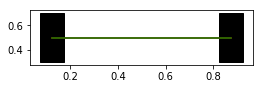

In [122]:
# Direct horizontal connections from left to right are one straight line
assertPath((0, 0), (3, 0), [], [(0, 0), (3,0)])

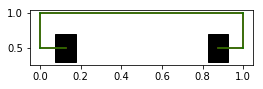

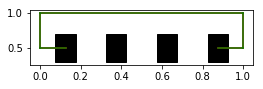

In [123]:
# Direct horizontal connections from right to left always evade on top, independent of obstacles
assertPath((3, 0), (0, 0), [], [(3, 0), (3.5, 0), (3.5, 0.5), (-0.5, 0.5), (-0.5, 0), (0, 0)])
assertPath((3, 0), (0, 0), [(1, 0), (2, 0)], [(3, 0), (3.5, 0), (3.5, 0.5), (-0.5, 0.5), (-0.5, 0), (0, 0)])

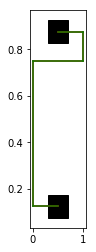

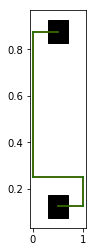

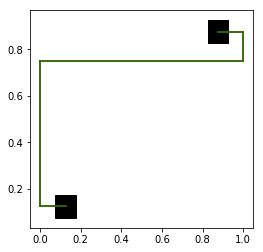

In [124]:
# When the target is not to the right of the source, always evade ASAP, and always connect from left
assertPath((0, 3), (0, 0), [], [(0, 3), (0.5, 3), (0.5, 2.5), (-0.5, 2.5), (-0.5, 0), (0, 0)])
assertPath((0, 0), (0, 3), [], [(0, 0), (0.5, 0), (0.5, 0.5), (-0.5, 0.5), (-0.5, 3), (0, 3)])
assertPath((3, 3), (0, 0), [], [(3,3), (3.5, 3), (3.5, 2.5), (-0.5, 2.5), (-0.5, 0), (0, 0)])

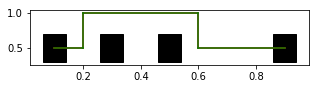

In [125]:
# If there are obstacles, evade as late as possible.
# Going back as early as possible looks nice but requires one extra collision detection
assertPath((0, 0), (4, 0), [(1, 0), (2, 0)], [(0, 0), (0.5, 0), (0.5, 0.5), (2.5, 0.5), (2.5, 0), (4,0)])

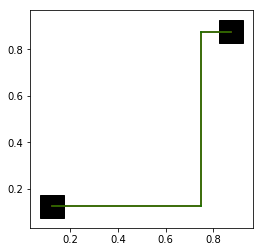

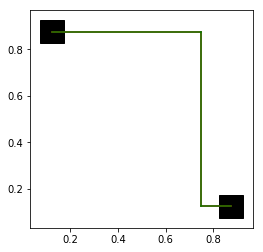

In [126]:
# When changing rows, evade as late as possible if there is no obstacle
# Vertical lines should always be drawn between columns, as the last segment always connects from the left
assertPath((0, 0), (3, 3), [], [(0, 0), (2.5, 0), (2.5, 3), (3,3)])
assertPath((0, 3), (3, 0), [], [(0, 3), (2.5, 3), (2.5, 0), (3,0)])

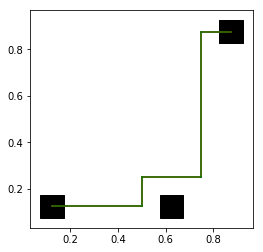

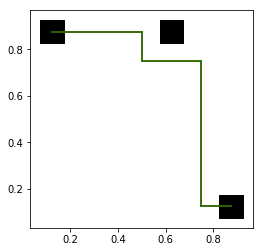

In [127]:
# Evade as soon as necessary, then follow shortest paths between obstacles
assertPath((0, 0), (3, 3), [(2,0)], [(0, 0), (1.5, 0), (1.5, 0.5), (2.5, 0.5), (2.5, 3), (3,3)])
assertPath((0, 3), (3, 0), [(2,3)], [(0, 3), (1.5, 3), (1.5, 2.5), (2.5, 2.5), (2.5, 0), (3, 0)])

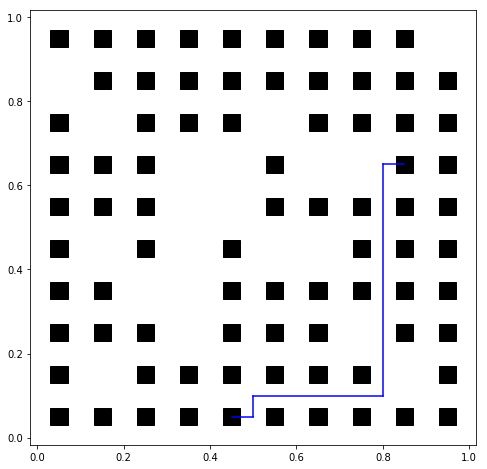

In [135]:
# generate a random path
points = generate_coordinates(10, 10, 80)
pairs = random_pairs_of_points(points, 1)
index = PointIndex(points)
segments = index.connect_all(pairs)
_ = Visualization(points, segments)

# Performance

Run a performance test. With a grid size of $200 \times 200$, we try up to $20000$ points, i.e. occupancy of $\frac{1}{2}$.

In [76]:
def setup(columns, rows, num_points, lines):
    points = generate_coordinates(columns, rows, num_points)
    index = PointIndex(points)
    pairs = random_pairs_of_points(points, lines)
    return index, pairs


runs = {}
for points in range(1, 20000, 100):
    runs[points] = timeit.repeat(stmt="i.connect_all(p)", setup=f"i,p=setup(200, 200, {points}, 5000)", repeat=1, number=1, globals=globals())[0]

Fit a curve that plausibly shows us that the expected runtime of collision detection grows logarithmically with the square root of the number of obstacles, i.e. $\mathop{\mathbb{E}}[T] \approx a + b \log_2\sqrt{n}$ for $n$ points and some suitable constants $a$ and $b$.

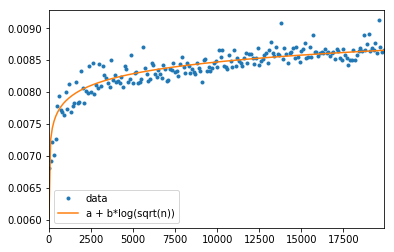

In [77]:
s = pd.Series(runs)
s.sort_index(inplace=True)

def log_runtime(n, a, b):
    return a + b * np.log(np.sqrt(n))
(a, b), _ = curve_fit(log_runtime, s.index.values, s.values)
nlogn_predictions = [log_runtime(x, a, b) for x in s.index.values]

plt.figure()
s.plot(style=".", label="data")
plt.plot(s.index.values, nlogn_predictions, label="a + b*log(sqrt(n))")
plt.legend()